In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
import math, random, numpy as np
import json
import datetime
from pathlib import Path
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchvision import models, transforms as T

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import (
normalized_mutual_info_score,
adjusted_rand_score,
homogeneity_score,
completeness_score,
davies_bouldin_score,
silhouette_score,
calinski_harabasz_score
)

from tqdm import tqdm

import h5py

from pyclustertend import hopkins

import time

from fvcore.nn import FlopCountAnalysis

In [19]:
LABELED_DATASET_PATH = '/data/TCD/labeled_data_ghent.h5'
LOGATEC_DATASET_PATH = '/data/LOG-a-TEC/test_data.h5'
LABELED_ITS_DATASET_PATH = '/data/ITS/labeled_data_ITS_band.h5'

In [20]:
# Setup GPU
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = False
    pin_memory = True
else:
    device = torch.device('cpu')
    pin_memory = False

#print("Current device: ", torch.cuda.current_device())  
print("Current device: ", torch.cuda.is_available())

Current device:  True


In [21]:
from deep_clastering.datasets import LogatecDataset, LabeledGhentDataset, LabeledITSDataset 
from deep_clastering.cnn import Simple_CNN_1D
from deep_clastering.visualization import get_averaged_clusters, plot_averaged_clusters_spectograms
from deep_clastering.visualization import plot_tsne, plot_labels_dist_across_clusters

In [32]:
def train_epoch(
    model, 
    optimizer,
    train_dataset,
    train_config
    ):
    """This function will train for single epoch. We use AMP (automatic mixed 
    precision) for faster computation."""
    
    num_workers = train_config['num_workers']
    batch_size = train_config['batch_size']
    
    # Construct dataset loader for Torch
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        pin_memory=pin_memory,
        drop_last=False,
        prefetch_factor=32
    )

    # Storage for tracking running loss
    running_loss = []
    # Progress bar for easier tracking of the status
    pbar = tqdm(train_loader, desc='training', unit='batch')
    model.train()
    for (images, labels) in pbar:
        # Load images and pseudo-labels
        images = images.to(device, torch.float32)
        labels = labels.to(device, torch.long)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # with torch.cuda.amp.autocast():
        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()
        # scaler.scale(loss).backward()

        # Update parameters
        optimizer.step()

        # Summary info (current loss)
        running_loss.append(loss.item())

        # Calculate running loss
        total_loss = sum(running_loss) / len(running_loss)

        # Obtain learning rate
        learning_rate = get_lr(optimizer)

        # Print progress and current state of the NN training
        pbar.set_postfix(loss=total_loss, lr=learning_rate)

        # Update scheduler
        #scheduler.step(total_loss)
    
    # Return stats
    return {'loss': total_loss, 'running_loss': running_loss}

def extract_features(model, dataset, train_config):
    
    num_workers = train_config['num_workers']
    batch_size = train_config['batch_size']
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        drop_last=False,
        prefetch_factor=32
    )
    
    features = []
    
    model_features = model.feature_layers
    model_features.eval()
    
    for imgs, labels in dataloader:
        imgs = imgs.to(device, torch.float32)
        cur_features = model_features(imgs).detach().cpu()
        features.append(cur_features.view((len(imgs), -1)))
        
    return torch.cat(features)
    
def make_clusters(
    model:nn.Module, 
    dataset:Dataset,
    train_config:set,
    k_means_init:np.ndarray|str="k-means++",
    batch_size:int=1024)->np.array:
    """
    k_means_init: starting point for clustering algorithm or "k-means++"
    Generate new pseudo labels for the dataset. See arXiv:1807.05520
    """
    kmeans_clusters = train_config['kmeans_clusters']
    pca_dim = train_config['kmeans_clusters']
    
    kmeans = MiniBatchKMeans(
        n_clusters=kmeans_clusters, 
        batch_size=batch_size, 
        init_size=3*kmeans_clusters, 
        n_init=3
    )
    
    pca = IncrementalPCA(
        n_components=pca_dim, 
        batch_size=batch_size, 
        whiten=True)
    
    # Extract features with NN
    features = extract_features(model, dataset, train_config)

    # Remove axes of length one since the output of the AvgPoolLayer is 4 dimensional.
    features = np.squeeze(features)

    # Remove possible NaN and inf values.
    features[np.isfinite(features)==False] = 0
    
    start_time = time.time()
    # Reduce feature space with PCA
    reduced = pca.fit_transform(features)

    # L2 normalization
    norm = np.linalg.norm(reduced, axis=1)
    reduced = reduced / norm[:, np.newaxis]
    
    end_time = time.time()
    print("--- %s seconds for PCA and L2 norm---" % (time.time() - start_time))

    # Perform clustering/pseudo-labeling with KMeans
    pseudo_labels = kmeans.fit_predict(reduced)
    
    return pseudo_labels, features, reduced, kmeans.cluster_centers_

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

In [36]:
def train(
    model,
    train_dataset,
    train_config
):
    # Train loop
    all_stats = []
    
    d_t_string = datetime.datetime.now().strftime("%H_%M_%S_%d_%m_%Y")
    
    print("\n=====Training parameters=====")
    print("Num clusters: ", train_config['kmeans_clusters'])
    print("Num classes: ", train_config['num_classes'])
    print("Max epochs: ", train_config['num_epochs'])
    print("PCA dimensions: ", train_config['pca_dim'])
    
    if hasattr(train_dataset, 'name'):
        dataset_name = train_dataset.name
    else:
        dataset_name = 'unknown_data'

    if hasattr(model, 'name'):
        model_name = model.name
    else: 
        model_name = 'unknown_model'
    
    SAVE_MODEL_PATH = (
        f"/results/models/{dataset_name}_{train_config['kmeans_clusters']}"
        f"pca_{train_config['pca_dim']}"
        f"_e_{train_config['num_epochs']}_{model_name}_{d_t_string}_.pt")
    

    SAVE_STAT_PATH = (
        f"/results/stats/{dataset_name}_{train_config['kmeans_clusters']}"
        f"pca_{train_config['pca_dim']}"
        f"_e_{train_config['num_epochs']}_{model_name}_{d_t_string}_stats.json")
    
    for epoch in range(train_config['num_epochs']):

        print("\n Epoch:")
        print(epoch)
        
        # generate labels
        if epoch > 0:
            prev_pseudo_labels = pseudo_labels
            
        if epoch == 0:
            cluster_centers = "k-means++"
            
        else:
                cluster_centers = prev_cluster_centers
        
        # make new clusters based on previous labling
        pseudo_labels, features, reduced, prev_cluster_centers \
        = make_clusters(model, train_dataset, train_config, cluster_centers)  

        # indicator for convergence
        if epoch > 0:
            nmi = normalized_mutual_info_score(prev_pseudo_labels, pseudo_labels)
            print(f"NMI t/t-1: {nmi}")
    
        # make new dataset with labels matched to images (Spectrum data)
        train_dataset.labels = pseudo_labels

        # Optimizer
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
        # Train for one epoch
        stats = train_epoch(model, optimizer, train_dataset, train_config)
        all_stats.append(stats)
    
        # Save the current model state.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': stats['running_loss'],
            }, SAVE_MODEL_PATH)

        # Save the stat data in .json file.
        with open(SAVE_STAT_PATH, 'w') as f:
            json.dump(all_stats, f, indent=2)
    

In [37]:
def calc_label_based_metrics(labels_a, labels_b):
    nmi = normalized_mutual_info_score(labels_a, labels_b)
    ari = adjusted_rand_score(labels_a, labels_b)
    hsc = homogeneity_score(labels_a, labels_b)
    cpl = completeness_score(labels_a, labels_b)
    
    return nmi, ari, hsc, cpl
    
    
def calc_distance_based_metrics(features, labels):
    db_score = 0
    h_score = 0
    s_score = 0
    ch_score = 0

    # Calculate Davis-Bouldin score
    db_score = davies_bouldin_score(features, labels)

    # Calculate Hopkins score
    h_score = hopkins(features, sampling_size=1000)

    # Calculate Silhouette score
    selected_ids = np.random.choice(len(features), size=1000)
    s_score = silhouette_score(features[selected_ids], labels[selected_ids], metric='euclidean')
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(features, labels)
    
    return db_score, h_score, s_score, ch_score
    
def calculate_complexity(model, train_dataset):
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")
    
    # Create DataLoader for training
    data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    single_batch = next(iter(data_loader))
    s = single_batch[0].to(device)

    flops = FlopCountAnalysis(model, s)
    print(f"GFLOPS: {flops.total()/1_000_000_000}")
    
    
def iterate_eval_kmeans_inits(pseudo_labels, labels_array, iter_num=100):
    nmi_list = np.zeros(iter_num)
    ari_list = np.zeros(iter_num)
    chs_list = np.zeros(iter_num)
    ccs_list = np.zeros(iter_num)
    for i in range(iter_num):
        kmeans = MiniBatchKMeans(n_clusters=KMEANS_CLUSTERS, batch_size=256, 
                                 init_size=3*KMEANS_CLUSTERS, random_state=i, n_init=3)
        pseudo_labels = list(kmeans.fit_predict(reduced))

        nmi, ari, chs, ccs = calc_label_based_metrics(labels_array, pseudo_labels)
        nmi_list.append(nmi)
        ari_list.append(ari)
        chs_list.append(chs)
        ccs_list.append(ccs)


    print('Best nmi for random_state=', np.argmax(nmi_list), ', nmi=', nmi_list.max())
    print('Best ari for random_state=', np.argmax(ari_list), ', ari=', ari_list.max())
    print('Best chs for random_state=', np.argmax(chs_list), ', hsc=', chs_list.max())
    print('Best ccs for random_state=', np.argmax(ccs_list), ', cpl=', ccs_list.max())

In [54]:
# Train loop

train_config = {
'batch_size': 1024,
'num_workers': 12,
'kmeans_clusters': 10,
'num_classes': 10,
'pca_dim': 20,
'num_epochs': 20 # should be ~250
}

model = Simple_CNN_1D(features_size = 100, n_classes=10)
model.to(device)

train_dataset = LogatecDataset(LOGATEC_DATASET_PATH, transform=torch.tensor, scale=True)

train(model, train_dataset, train_config)
        


=====Training parameters=====
Num clusters:  10
Num classes:  10
Max epochs:  20
PCA dimensions:  20

 Epoch:
0
--- 6.824634552001953 seconds for PCA and L2 norm---


training: 100%|██████████| 417/417 [00:25<00:00, 16.17batch/s, loss=0.874, lr=0.0001]



 Epoch:
1
--- 5.950941801071167 seconds for PCA and L2 norm---
NMI t/t-1: 0.5332283988882653


training: 100%|██████████| 417/417 [00:17<00:00, 23.49batch/s, loss=0.855, lr=0.0001]



 Epoch:
2
--- 4.845697641372681 seconds for PCA and L2 norm---
NMI t/t-1: 0.6190940415649312


training: 100%|██████████| 417/417 [00:17<00:00, 23.31batch/s, loss=0.606, lr=0.0001]



 Epoch:
3
--- 6.963032007217407 seconds for PCA and L2 norm---
NMI t/t-1: 0.7177166197747212


training: 100%|██████████| 417/417 [00:18<00:00, 22.90batch/s, loss=0.691, lr=0.0001]



 Epoch:
4
--- 4.882748365402222 seconds for PCA and L2 norm---
NMI t/t-1: 0.7658407062141075


training: 100%|██████████| 417/417 [00:17<00:00, 23.43batch/s, loss=0.824, lr=0.0001]



 Epoch:
5
--- 6.589449644088745 seconds for PCA and L2 norm---
NMI t/t-1: 0.8009953098286766


training: 100%|██████████| 417/417 [00:17<00:00, 23.73batch/s, loss=0.66, lr=0.0001] 



 Epoch:
6
--- 6.981846570968628 seconds for PCA and L2 norm---
NMI t/t-1: 0.7536843304408433


training: 100%|██████████| 417/417 [00:18<00:00, 22.80batch/s, loss=0.608, lr=0.0001]



 Epoch:
7
--- 8.900466442108154 seconds for PCA and L2 norm---
NMI t/t-1: 0.6692191834505894


training: 100%|██████████| 417/417 [00:17<00:00, 23.83batch/s, loss=0.585, lr=0.0001]



 Epoch:
8
--- 6.699428558349609 seconds for PCA and L2 norm---
NMI t/t-1: 0.672081856999589


training: 100%|██████████| 417/417 [00:18<00:00, 23.11batch/s, loss=0.627, lr=0.0001]



 Epoch:
9
--- 4.8800208568573 seconds for PCA and L2 norm---
NMI t/t-1: 0.7322343259201161


training: 100%|██████████| 417/417 [00:17<00:00, 23.49batch/s, loss=0.488, lr=0.0001]



 Epoch:
10
--- 3.943901777267456 seconds for PCA and L2 norm---
NMI t/t-1: 0.5880128708358383


training: 100%|██████████| 417/417 [00:19<00:00, 21.56batch/s, loss=0.782, lr=0.0001]



 Epoch:
11
--- 5.1453540325164795 seconds for PCA and L2 norm---
NMI t/t-1: 0.6676053485923341


training: 100%|██████████| 417/417 [00:18<00:00, 22.97batch/s, loss=0.516, lr=0.0001]



 Epoch:
12
--- 7.233211517333984 seconds for PCA and L2 norm---
NMI t/t-1: 0.7613309227804943


training: 100%|██████████| 417/417 [00:18<00:00, 23.16batch/s, loss=0.675, lr=0.0001]


 Epoch:
13


--- 5.83152174949646 seconds for PCA and L2 norm---
NMI t/t-1: 0.6577840557797404


training: 100%|██████████| 417/417 [00:17<00:00, 24.04batch/s, loss=0.576, lr=0.0001]



 Epoch:
14
--- 5.673748970031738 seconds for PCA and L2 norm---
NMI t/t-1: 0.6860957439324322


training: 100%|██████████| 417/417 [00:17<00:00, 23.59batch/s, loss=0.69, lr=0.0001] 



 Epoch:
15
--- 6.236758232116699 seconds for PCA and L2 norm---
NMI t/t-1: 0.6531373318134548


training: 100%|██████████| 417/417 [00:17<00:00, 23.21batch/s, loss=0.555, lr=0.0001]



 Epoch:
16
--- 6.312098503112793 seconds for PCA and L2 norm---
NMI t/t-1: 0.6570858096829734


training: 100%|██████████| 417/417 [00:17<00:00, 23.25batch/s, loss=0.58, lr=0.0001] 



 Epoch:
17
--- 5.182872295379639 seconds for PCA and L2 norm---
NMI t/t-1: 0.7393831663660853


training: 100%|██████████| 417/417 [00:17<00:00, 23.18batch/s, loss=0.482, lr=0.0001]



 Epoch:
18
--- 5.204843282699585 seconds for PCA and L2 norm---
NMI t/t-1: 0.6527444018619584


training: 100%|██████████| 417/417 [00:18<00:00, 22.94batch/s, loss=0.638, lr=0.0001]



 Epoch:
19
--- 6.8442299365997314 seconds for PCA and L2 norm---
NMI t/t-1: 0.6935365111509952


training: 100%|██████████| 417/417 [00:19<00:00, 21.23batch/s, loss=0.592, lr=0.0001]


In [57]:
train_dataset = LogatecDataset(LOGATEC_DATASET_PATH, transform=torch.tensor, scale=True)

model_filename = '''/results/models/LogatecDataset_10pca_20_e_20_Simple_CNN_1D_13_23_13_11_09_2024_.pt'''
model = Simple_CNN_1D(n_classes=10)

# Optimizer for NN
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Load model
checkpoint = torch.load(model_filename, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Loading of the optimizer should be done after the model transfer to device
# in order to avoid loading optimizer on cpu. Solution found on:
# https://github.com/pytorch/pytorch/issues/8741
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loaded_epoch = checkpoint['epoch'] + 1 # Add 1 because of 0-indexing
loss = checkpoint['loss']

model.to(device)

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_4194/1070906129.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_filename, map_location=device)
/tmp/ipykernel_4194/10709061

In [61]:
pca = IncrementalPCA(n_components=train_config['pca_dim'], batch_size=256, whiten=True)

kmeans = MiniBatchKMeans(n_clusters=train_config['num_classes'], batch_size=256, 
                         init_size=3*train_config['num_classes'], random_state=97, n_init=3)

pseudo_labels, features, reduced, _ = make_clusters(model, train_dataset, train_config)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc405d64400>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc405d64400>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py", l

--- 6.103710889816284 seconds for PCA and L2 norm---


In [62]:
spectograms = []
labels = []

selected_indices = np.random.choice(len(train_dataset), size = 10000)

for i in selected_indices:
    spectograms.append(train_dataset[i][0][0].numpy())
    labels.append(train_dataset[i][1])
    
spectograms = np.array(spectograms)
    
averaged_clusters, cluster_real_classes \
=get_averaged_clusters(pseudo_labels[selected_indices], spectograms)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Average per-cluster'}, xlabel='FFT bins'>)

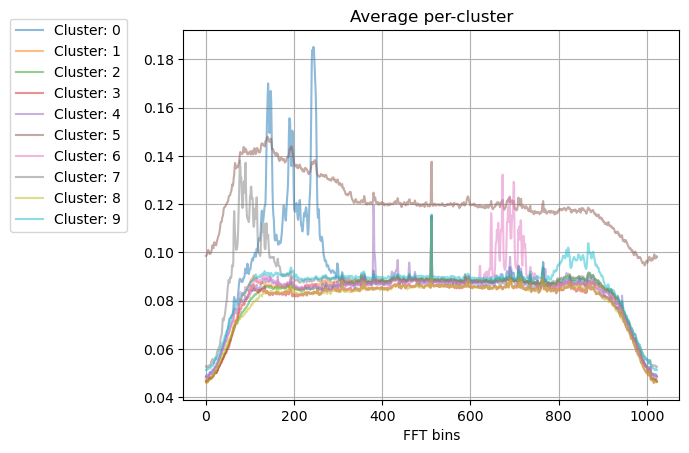

In [63]:
plot_averaged_clusters_spectograms(averaged_clusters)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

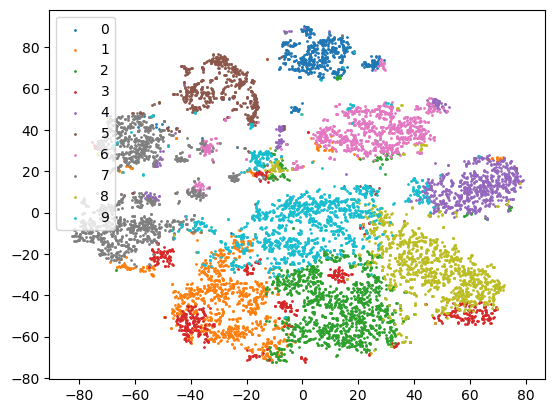

In [64]:
plot_tsne(pseudo_labels[selected_indices], reduced[selected_indices] )

In [47]:
train_config = {
'batch_size': 1024,
'num_workers': 12,
'kmeans_clusters': 10,
'num_classes': 10,
'pca_dim': 20,
'num_epochs': 20, # should be ~250
}

model = Simple_CNN_1D(features_size = 100, n_classes=10)
model.to(device)

train_dataset = LabeledGhentDataset(LABELED_DATASET_PATH, transform=torch.tensor, scale=True)

train(model, train_dataset, train_config)


=====Training parameters=====
Num clusters:  10
Num classes:  10
Max epochs:  20
PCA dimensions:  20

 Epoch:
0
--- 4.6264519691467285 seconds for PCA and L2 norm---


training: 100%|██████████| 172/172 [00:12<00:00, 13.91batch/s, loss=1.27, lr=0.0001]


 Epoch:
1


--- 4.639176368713379 seconds for PCA and L2 norm---
NMI t/t-1: 0.49972140348063426


training: 100%|██████████| 172/172 [00:13<00:00, 13.11batch/s, loss=0.764, lr=0.0001]


 Epoch:
2


--- 3.6240768432617188 seconds for PCA and L2 norm---
NMI t/t-1: 0.8210555037230002


training: 100%|██████████| 172/172 [00:12<00:00, 13.74batch/s, loss=0.68, lr=0.0001] 


 Epoch:
3


--- 4.549691200256348 seconds for PCA and L2 norm---
NMI t/t-1: 0.8012556644880674


training: 100%|██████████| 172/172 [00:12<00:00, 13.37batch/s, loss=0.969, lr=0.0001]


 Epoch:
4


--- 3.4536917209625244 seconds for PCA and L2 norm---
NMI t/t-1: 0.8181048407051777


training: 100%|██████████| 172/172 [00:12<00:00, 13.57batch/s, loss=0.673, lr=0.0001]


 Epoch:
5


--- 2.889206647872925 seconds for PCA and L2 norm---
NMI t/t-1: 0.8745510560443398


training: 100%|██████████| 172/172 [00:12<00:00, 13.49batch/s, loss=0.82, lr=0.0001] 


 Epoch:
6


--- 4.32286262512207 seconds for PCA and L2 norm---
NMI t/t-1: 0.8065725235645455


training: 100%|██████████| 172/172 [00:12<00:00, 13.29batch/s, loss=0.686, lr=0.0001]


 Epoch:
7


--- 3.4275145530700684 seconds for PCA and L2 norm---
NMI t/t-1: 0.9163866980963274


training: 100%|██████████| 172/172 [00:12<00:00, 13.41batch/s, loss=0.864, lr=0.0001]


 Epoch:
8


--- 3.0912232398986816 seconds for PCA and L2 norm---
NMI t/t-1: 0.8989267205039979


training: 100%|██████████| 172/172 [00:12<00:00, 13.43batch/s, loss=0.56, lr=0.0001] 


 Epoch:
9


--- 3.543163776397705 seconds for PCA and L2 norm---
NMI t/t-1: 0.9425935755361383


training: 100%|██████████| 172/172 [00:12<00:00, 13.66batch/s, loss=0.545, lr=0.0001]


 Epoch:
10


--- 4.168211936950684 seconds for PCA and L2 norm---
NMI t/t-1: 0.9523663598568223


training: 100%|██████████| 172/172 [00:12<00:00, 13.55batch/s, loss=0.67, lr=0.0001] 


 Epoch:
11


--- 3.7541747093200684 seconds for PCA and L2 norm---
NMI t/t-1: 0.8823219501074405


training: 100%|██████████| 172/172 [00:12<00:00, 13.49batch/s, loss=0.606, lr=0.0001]


 Epoch:
12


--- 3.6586151123046875 seconds for PCA and L2 norm---
NMI t/t-1: 0.8633309293775755


training: 100%|██████████| 172/172 [00:12<00:00, 13.41batch/s, loss=0.769, lr=0.0001]


 Epoch:
13


--- 2.515371322631836 seconds for PCA and L2 norm---
NMI t/t-1: 0.8939674904507999


training: 100%|██████████| 172/172 [00:12<00:00, 13.68batch/s, loss=0.361, lr=0.0001]


 Epoch:
14


--- 2.399705410003662 seconds for PCA and L2 norm---
NMI t/t-1: 0.8902380742994468


training: 100%|██████████| 172/172 [00:12<00:00, 13.60batch/s, loss=0.753, lr=0.0001]


 Epoch:
15


--- 2.2895822525024414 seconds for PCA and L2 norm---
NMI t/t-1: 0.8728812625762346


training: 100%|██████████| 172/172 [00:12<00:00, 13.76batch/s, loss=0.669, lr=0.0001]


 Epoch:
16


--- 5.422473430633545 seconds for PCA and L2 norm---
NMI t/t-1: 0.8970681443624581


training: 100%|██████████| 172/172 [00:12<00:00, 13.25batch/s, loss=0.548, lr=0.0001]


 Epoch:
17


--- 2.0964653491973877 seconds for PCA and L2 norm---
NMI t/t-1: 0.8826391649006735


training: 100%|██████████| 172/172 [00:12<00:00, 13.36batch/s, loss=0.515, lr=0.0001]


 Epoch:
18


--- 4.857782363891602 seconds for PCA and L2 norm---
NMI t/t-1: 0.9078166455788335


training: 100%|██████████| 172/172 [00:12<00:00, 13.37batch/s, loss=0.626, lr=0.0001]



 Epoch:
19
--- 3.132323741912842 seconds for PCA and L2 norm---
NMI t/t-1: 0.8293126811300195


training: 100%|██████████| 172/172 [00:13<00:00, 12.95batch/s, loss=0.781, lr=0.0001]


In [48]:
train_dataset = LabeledGhentDataset(LABELED_DATASET_PATH, transform=torch.tensor, scale=True)

model_filename = '/results/models/LabeledGhentDataset_10pca_20_e_20_Simple_CNN_1D_12_55_50_11_09_2024_.pt'
model = Simple_CNN_1D(n_classes=10)

# Optimizer for NN
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Load model
checkpoint = torch.load(model_filename, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Loading of the optimizer should be done after the model transfer to device
# in order to avoid loading optimizer on cpu. Solution found on:
# https://github.com/pytorch/pytorch/issues/8741
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loaded_epoch = checkpoint['epoch'] + 1 # Add 1 because of 0-indexing
loss = checkpoint['loss']

model.to(device)

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_4194/1875273914.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_filename, map_location=device)
/tmp/ipykernel_4194/18752739

In [49]:
pca = IncrementalPCA(n_components=train_config['pca_dim'], batch_size=256, whiten=True)

kmeans = MiniBatchKMeans(n_clusters=train_config['num_classes'], batch_size=256, 
                         init_size=3*train_config['num_classes'], random_state=97, n_init=3)

pseudo_labels, features, reduced, _ = make_clusters(model, train_dataset, train_config)

--- 2.7878568172454834 seconds for PCA and L2 norm---


In [50]:
spectograms = []
labels = []

selected_indices = np.random.choice(len(train_dataset), size = 10000)

for i in selected_indices:
    spectograms.append(train_dataset[i][0][0].numpy())
    labels.append(train_dataset[i][1])
    
spectograms = np.array(spectograms)


averaged_clusters, clusters_centers \
= get_averaged_clusters(pseudo_labels[selected_indices], spectograms)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Average per-cluster'}, xlabel='FFT bins'>)

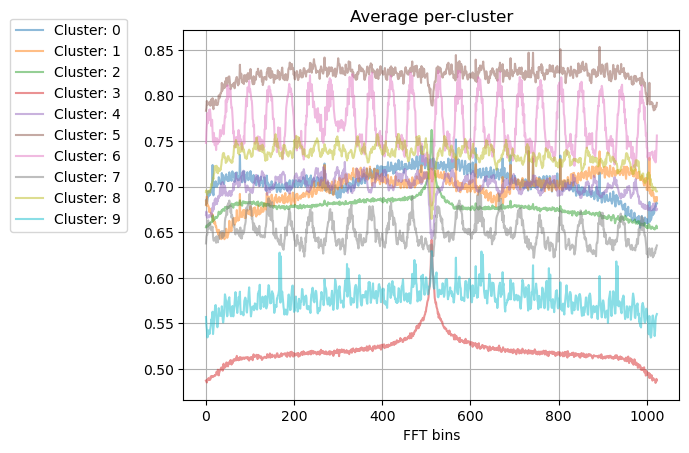

In [51]:
plot_averaged_clusters_spectograms(averaged_clusters)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

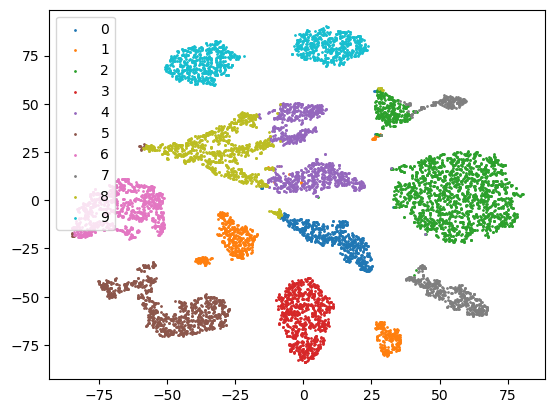

In [52]:
plot_tsne(pseudo_labels[selected_indices], reduced[selected_indices] )